# Six-bar mechanism balancing

###### Luis Eduardo Robles Jiménez

In [1]:
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

#### Constraints

$$ -0.16m \leq x_{cn}, y_{cn} \leq 0.16m $$

$$ 0.005m \leq t_{cn} \leq 0.04m $$

### Read data from a file

In [2]:
"""
# The very best examples, to understand how good solutions behave
fitness = np.loadtxt("1671649703Fitness.txt")
samples = np.loadtxt("1671649703Population.txt")
# Solutions under 1.0
fitness = np.loadtxt("1671919014Fitness.txt")
samples = np.loadtxt("1671919014Population.txt")
# Broader space
# 10% best solutions, 50% Under 1.0 solutions, 50% random solutions.
samples = np.loadtxt("1671988185Population.txt")
fitness = np.loadtxt("1671988185Fitness.txt")
shForces = np.loadtxt("1671988185ShForces.txt")
shMoments = np.loadtxt("1671988185ShMoments.txt")
# More pymoo results
samples = np.loadtxt("1674756309Population.txt")
fitness = np.loadtxt("1674756309Fitness.txt")
shForces = np.loadtxt("1674756309ShForces.txt")
shMoments = np.loadtxt("1674756309ShMoments.txt")
# 114 crazy estimations with a random uniform alpha (0 pairs below 1)
samples = np.loadtxt("1675557893Population.txt")
fitness = np.loadtxt("1675557893Fitness.txt")
shForces = np.loadtxt("1675557893ShForces.txt")
shMoments = np.loadtxt("1675557893ShMoments.txt")
"""
# DE with random alpha
samples = np.loadtxt("experiments/1676302198Population.txt")
fitness = np.loadtxt("experiments/1676302198Fitness.txt")
shForces = np.loadtxt("experiments/1676302198ShForces.txt")
shMoments = np.loadtxt("experiments/1676302198ShMoments.txt")

print(samples.shape)
print(fitness.shape)
print(shForces.shape)
print(shMoments.shape)

(77, 15)
(77,)
(77,)
(77,)


In [3]:
nSamples, nVariables = samples.shape
nWeights = nVariables // 3
globalMax = np.max(samples)
globalMin = np.min(samples)

## Dimensionality reduction

### Feature extraction

#### Thicknesses

In [5]:
thicknesses = samples[:, 2::3]

#### Radiuses

In [6]:
radiuses = np.sqrt(np.square(samples[:, ::3]) + np.square(samples[:, 1::3]))

#### Masses

This is a problem-specific feature that can be got from variables.

These calculations are intended to be used later on to find out whether this is a good representant of the solutions or not.

The mass can be easily calculated with the resulting formula of the following steps.

##### Formula

$$\sigma_i = \frac{m_i}{V_i}$$

$$m_i = V_i \sigma_i$$

$$m_i = (r_i^2 t_i \pi)(\sigma_i)$$

$$m_i = (\sqrt{x_i^2 + y_i^2}^2 t_i \pi)(\sigma_i)$$

$$m_i = (x_i^2 + y_i^2) t_i \pi\sigma_i$$

##### Considering that

$\sigma$ is density. In this problem: $\sigma_i = 7800 \frac{kg}{m^3}$

$m$ is mass $(kg)$

$V$ is volume; of a cylinder in this problem $(m^3)$ 

$x, y$ are the relative coordinates of the weight centers. $(m)$

In [7]:
masses = np.zeros((nSamples, nWeights))
density = 7800
for i in range(nWeights):
    masses[:, i] = (samples[:, i*3]**2 + samples[:, i*3 + 1]**2) * samples[:, i*3 + 2] * np.pi * density
sumMasses = np.sum(masses, axis = 1)

#### PCA

In [8]:
modelPCA = PCA()
modelPCA.fit(samples)
dataPCA = modelPCA.transform(samples)
dataPCA.shape

(77, 15)

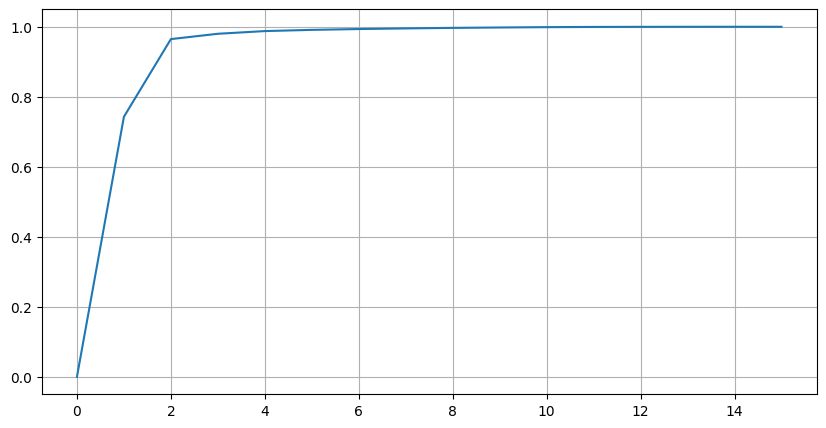

In [9]:
expVar = modelPCA.explained_variance_ratio_
expVarCum = np.cumsum(expVar)
plt.figure(figsize=(10, 5))
plt.grid()
plt.plot(np.concatenate(([0], expVarCum)))
plt.show()

##### First two main components

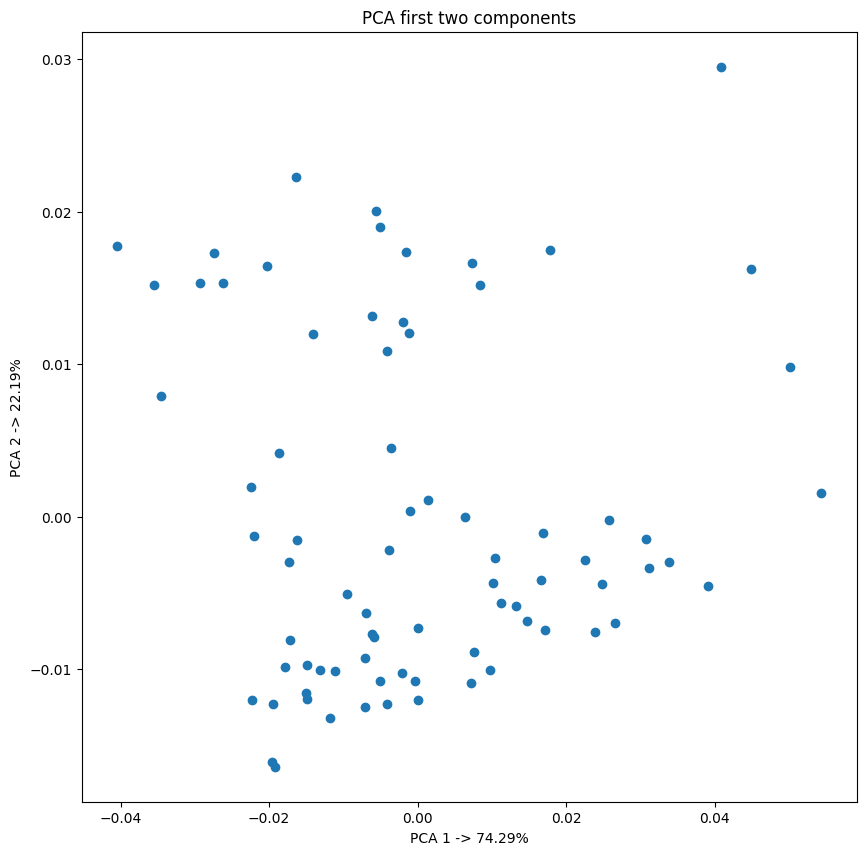

In [10]:
dataPCA = dataPCA[:, :2]
plt.figure(figsize=(10, 10))
plt.title("PCA first two components")
plt.scatter(dataPCA[:, 0], dataPCA[:, 1])
plt.xlabel("PCA 1 -> " + str(np.round(expVar[0]*100, 2)) + "%")
plt.ylabel("PCA 2 -> " + str(np.round(expVar[1]*100, 2)) + "%")
plt.show()

## Data visualization

### Parallel coordinates 

#### All variables

Decent solutions seem to follow a pattern of trying to find the equilibrium between thickness and position. So the weights might be optimal with a determined mass value.

In [45]:
figure = []
features = ["x One", "y One", "t One", "x Two", "y Two", "t Two", "x Three", "y Three", "t Three", "x Four", "y Four", "t Four", "x Five", "y Five", "t Five"]
for i in range(samples.shape[1]):
    #figure.append(dict(range = [globalMin, globalMax], label = features[i], values = samples[:, i]))
    figure.append(dict(label = features[i], values = samples[:, i]))
figure.append(dict(label = 'Fitness', values = fitness))

In [46]:
fig = go.Figure(data =
    go.Parcoords(
        line = dict(color = fitness, colorscale = px.colors.sequential.Jet),
        dimensions = figure
    )
)
fig.show()

In [47]:
fig = px.parallel_coordinates(samples, title = "Mechanism balancing samples",
                            #color = fitness,
                            labels=["x One", "y One", "t One", "x Two", "y Two", "t Two", "x Three", "y Three", "t Three", "x Four", "y Four", "t Four", "x Five", "y Five", "t Five", "Fitness"],
                            color_continuous_scale=px.colors.sequential.Jet)
fig.show()

#### Masses

The masses seem to describe a consistent behavior on their weights. 

In [ ]:
fig = px.parallel_coordinates(masses, title = "Samples' masses",
                            #color = fitness,
                            labels=["mass One", "mass Two", "mass Three", "mass Four", "mass Five", "Fitness"],
                            color_continuous_scale=px.colors.sequential.Jet)
fig.show()

#### Shaking moment vs Shaking force

This graph shows the behavior of the Pareto efficient solutions, where the improvement on the optimization of one variable, directly affects others'.

In [ ]:
fig = px.parallel_coordinates({"Shaking Moment": shMoments[optimal], "Shaking Force": shForces[optimal], "Fitness": fitness[optimal]}, title = "Multiobjective optimization behavior",
                            color = "Fitness",
                            color_continuous_scale=px.colors.sequential.Jet)
fig.show()

### Violinplot

This graph is created with hopes of seeing if  masses have a tendency. 

These graphs help to show:

1. Weight 1 has a short range where it values are optimal, and the frequency seems to indicate that the smaller it is, the better it works.

2. Weight 2 shows an interesting dynamic range, it's large and might ressemble a normal distribution.

3. Weight 3 clearly shows it's tendency for a specific mass near the maximum limit.

4. Weight 4 seems optimal when it's as small as possible.

5. Weight 5 same behavior as 4.

In [ ]:
fig = plt.figure(figsize =(15, 15))
plt.subplot(2, 1, 1)
plt.title("Distribution of the optimal weights in kg")
plt.xlabel("# of weight")
plt.ylabel("Mass (kg)")
plt.violinplot(masses[optimal])
plt.subplot(2, 1, 2)
plt.title("Weights")
plt.violinplot(masses)

### Scatter plot

Let's try to see if there's a relation between the masses of the weights and their fitness.

#### Observations

- Fwiw, points above the optimal ones mean that the results can be heavily affected by other variables.

- Checkout the previous [results](https://github.com/LuisR-jpg/School/blob/af30b7fbc78e681a47fba3b86f7624ddf7c9c180/Courses%20and%20Miscellaneous/Research/GraphicalAnalysis.ipynb)

In [ ]:
fig = plt.figure(figsize =(15, 30))
for i in range(nWeights):
    plt.subplot(5, 2, i*2 + 1)
    plt.title("Weight " + str(i + 1))
    plt.scatter(masses[:, i], fitness, alpha = 0.3, c = fitness, cmap = 'jet')
    plt.xlabel("Mass")
    plt.ylabel("Fitness")
    plt.subplot(5, 2, i*2 + 2)
    plt.title("Optimal Weight " + str(i + 1))
    plt.scatter(masses[optimal, i], fitness[optimal], alpha = 0.3, color = '0')
    plt.xlabel("Mass")
    plt.ylabel("Fitness")

In [ ]:
fig = plt.figure(figsize =(10, 10))
colors = ['k', 'b', 'g', 'r', 'lime']
for i in range(nWeights):
    plt.title("Weights")
    plt.scatter(masses[:, i], fitness, alpha = 0.6, color = colors[i], label = "Weight " + str(i + 1))
    plt.xlabel("Mass")
    plt.ylabel("Fitness")
plt.legend()

#### Total mass

It's possible to see how worse the solutions get with weights that are outside a determined range.

In [ ]:
plt.figure(figsize=(15, 10))
plt.grid(which="both")
plt.subplot(1, 2, 1)
plt.scatter(sumMasses, fitness, alpha = 0.3, color = '0')
plt.title("Behavior of total mass")
plt.xlabel("Total mass")
plt.ylabel("Fitness")
plt.subplot(1, 2, 2)
plt.title("Optimal aggregated mass in kg")
plt.ylabel("Mass")
plt.violinplot(sumMasses[optimal])

#### Relation between thickness and radius

- Once again, it demonstrates that these two variables work together to reach the optimal mass.

In [ ]:
plt.figure(figsize=(15, 15))
for w in range(1, nWeights + 1):
    plt.subplot(3, 2, w)
    weight = w - 1
    plt.scatter(radiuses[optimal, weight], thicknesses[optimal, weight], c = fitness[optimal], alpha = 0.5, cmap = "jet")
    plt.xlabel("Radius " + str(w))
    plt.ylabel("Thickness " + str(w))

#### Fitness 

This feature is the average of both functions

In [ ]:
plt.figure(figsize = (7, 7))
plt.plot(range(np.sum(optimal)), shForces[optimal], c = 'r', alpha = 0.5)
plt.scatter(range(np.sum(optimal)), shForces[optimal], c = 'r', alpha = 0.5)
plt.plot(range(np.sum(optimal)), fitness[optimal], c = "0")
plt.scatter(range(np.sum(optimal)), fitness[optimal], c = "0")
plt.plot(range(np.sum(optimal)), shMoments[optimal], c = 'b', alpha = 0.5)
plt.scatter(range(np.sum(optimal)), shMoments[optimal], c = 'b', alpha = 0.5)
plt.grid(which="both")

#### Pareto front

A more common way to show the Pareto front.

In [ ]:
plt.figure(figsize = (7, 7))
plt.scatter(shForces[optimal], shMoments[optimal], alpha = 0.5, c = fitness[optimal], cmap = "jet")
plt.title("Optimal pareto front")
plt.xlabel("Shaking Forces")
plt.ylabel("Shaking Moment")

In [ ]:
plt.figure(figsize = (7, 7))
plt.scatter(shForces, shMoments, alpha = 0.5, c = fitness, cmap = "jet")
plt.xlabel("Shaking Forces")
plt.ylabel("Shaking Moment")

## Pareto Front comparison

In [ ]:
fitnessTwo = np.loadtxt("1676338610Fitness.txt")
shForcesTwo = np.loadtxt("1676338610ShForces.txt")
shMomentsTwo = np.loadtxt("1676338610ShMoments.txt")

aTwo = shForcesTwo < 1
bTwo = shMomentsTwo < 1
optimalTwo = np.logical_and(aTwo, bTwo)

plt.figure(figsize = (15, 7.5))

plt.subplot(1, 2, 1)
plt.xlim(0, np.max([np.max([shForces[optimal]]), np.max([shForcesTwo[optimalTwo]])]))
plt.ylim(0, np.max([np.max([shMoments[optimal]]), np.max([shMomentsTwo[optimalTwo]])]))
plt.scatter(shForces[optimal], shMoments[optimal], alpha = 0.5, c = fitness[optimal], cmap = "jet")
plt.xlabel("Shaking Forces")
plt.ylabel("Shaking Moment")
plt.title("Current Pareto Front")

plt.subplot(1, 2, 2)
plt.xlim(0, np.max([np.max([shForces[optimal]]), np.max([shForcesTwo[optimalTwo]])]))
plt.ylim(0, np.max([np.max([shMoments[optimal]]), np.max([shMomentsTwo[optimalTwo]])]))
plt.scatter(shForcesTwo[optimalTwo], shMomentsTwo[optimalTwo], alpha = 0.5, c = fitnessTwo[optimalTwo], cmap = "jet")
plt.xlabel("Shaking Forces")
plt.ylabel("Shaking Moment")
plt.title("Comparison Pareto Front")

In [ ]:
plt.figure(figsize = (7, 7))

plt.xlim(0, np.max([np.max([shForces[optimal]]), np.max([shForcesTwo[optimalTwo]])]))
plt.ylim(0, np.max([np.max([shMoments[optimal]]), np.max([shMomentsTwo[optimalTwo]])]))
plt.scatter(shForcesTwo[optimalTwo], shMomentsTwo[optimalTwo], c = fitnessTwo[optimalTwo], cmap = "jet", marker="x", s = 2)
#plt.scatter(shForcesTwo[optimalTwo], shMomentsTwo[optimalTwo])
plt.scatter(shForces[optimal], shMoments[optimal], c = fitness[optimal], cmap = "jet", marker = 'o')
plt.xlabel("Shaking Forces")
plt.ylabel("Shaking Moment")
plt.title("Comparison Pareto Front")